In [52]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
from IPython.display import Audio
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, Model, optimizers

In [53]:
#Data Augmentation 
# Noise Injection 
#Shifting time 
#Changing the pitch 
#Speed 
# Time wrapping 
# Frequency Masking 
# Time Masking 

In [54]:
audio = "/home/divyansh/Divyansh/projects/senti_random_forest/data/"

In [55]:
audio_df = pd.read_csv('/home/divyansh/Divyansh/projects/senti_random_forest/audio.csv', usecols= ['emotion', 'path', 'gender', 'actor' ])

In [56]:
audio_df.head()

,gender,emotion,actor,path
0,male,neutral,1,/home/divyansh/Divyansh/projects/senti_random_...
1,male,fear,1,/home/divyansh/Divyansh/projects/senti_random_...
2,male,angry,1,/home/divyansh/Divyansh/projects/senti_random_...
3,male,happy,1,/home/divyansh/Divyansh/projects/senti_random_...
4,male,sad,1,/home/divyansh/Divyansh/projects/senti_random_...


In [57]:
train, test = train_test_split(audio_df, test_size=0.2, random_state= 0, 
                               stratify=audio_df[['emotion', 'gender', 'actor']])

In [58]:
X_train = train.iloc[:,3:]
y_train = train.iloc[:,:2].drop(columns = ['gender'])

In [59]:
print(X_train.shape)

(1152, 1)


Adding the noise, stretch, speed and Pitch to the audio file 


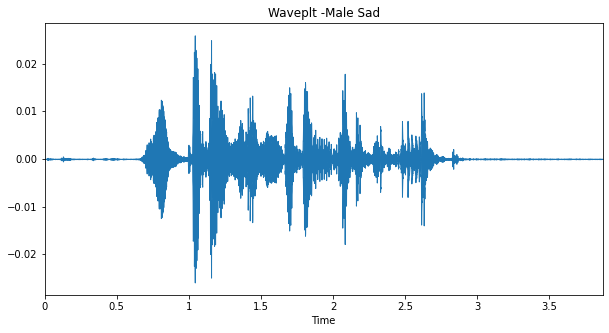

In [60]:
fname = audio + 'Actor_09/03-01-04-02-02-02-09.wav'
x,sr = librosa.load(fname)
plt.figure(figsize=(10,5))
librosa.display.waveplot(x,sr=sr)
plt.title('Waveplt -Male Sad')
plt.savefig('Waveplot_MaleSad.png')

In [61]:
#Adding the noise 
def noise(x):
    noise_amp = 0.05* np.random.uniform()*np.amax(x)
    x = x.astype('float64') + noise_amp * np.random.normal(size = x.shape[0])
    return x

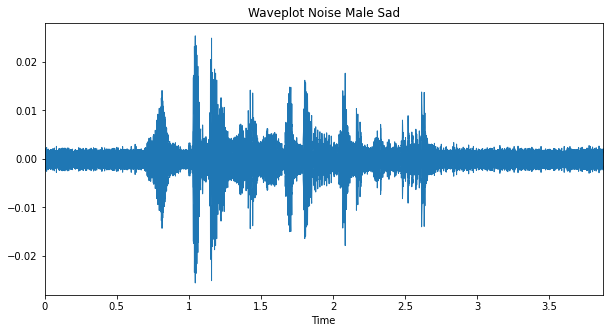

In [62]:
x = noise(x)
plt.figure(figsize=(10,5))
librosa.display.waveplot(x,sr=sr)
plt.title('Waveplot Noise Male Sad')
plt.savefig('Wave_MaleSadNoise.png')

In [63]:
#function to stretch the sound 
def stretch(x, rate=0.8):
    data = librosa.effects.time_stretch(x,rate)
    return data


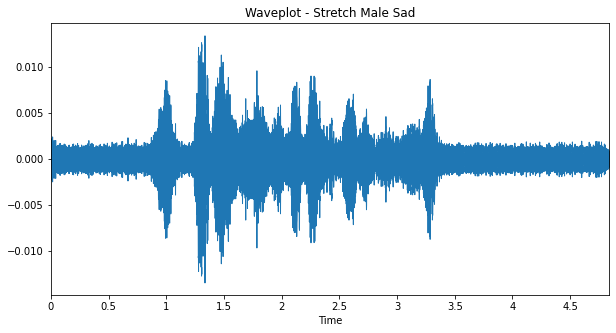

In [64]:
x = stretch(x)
plt.figure(figsize=(10,5))
librosa.display.waveplot(x,sr=sr)
plt.title('Waveplot - Stretch Male Sad')
plt.savefig('Waveplot_MaleSadStretch.png')


In [65]:
#function to increase the speed and the pitch 
def speedNpitch(x):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.4/ length_change
    tmp = np.interp(np.arange(0,len(x), speed_fac), np.arange(0,len(x)),x)
    minlen = min(x.shape[0], tmp.shape[0])
    x*=0
    x[0:minlen] = tmp[0:minlen]
    return x

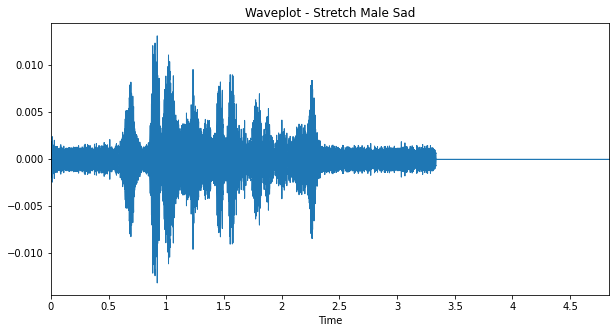

In [66]:
x = speedNpitch(x)
plt.figure(figsize=(10,5))
librosa.display.waveplot(x,sr=sr)
plt.title('Waveplot - Stretch Male Sad')
plt.savefig('Waveplot_MaleSpeedNPitch.png')


In [67]:
#Applying the Data Augmentation methods to train set 

df = pd.DataFrame(columns=['log_spec'])
counter = 0

for index,path in enumerate(train.path):
    #for the wave representation 
    X,sample_Rate = librosa.load(path, res_type='kaiser_fast', duration= 3, sr= 44100, offset= 0.5)
    spectogram = librosa.feature.melspectrogram(y=X, sr=sample_Rate, n_mels=128, fmax = 8000)
    db_spec = librosa.power_to_db(spectogram)
    log_spectogram = np.mean(db_spec, axis = 0)
    df.loc[counter] = [log_spectogram]
    counter += 1
print(len(df))
df.head()
    

1152


,log_spec
0,"[-67.48485, -67.48485, -67.48485, -67.48485, -..."
1,"[-70.23177, -69.54781, -69.33392, -69.498695, ..."
2,"[-61.203438, -61.185642, -56.77076, -54.75769,..."
3,"[-45.199844, -43.82312, -44.344078, -45.735817..."
4,"[-70.07283, -69.86238, -69.91055, -69.819855, ..."


In [68]:
# ADD NOISE AND USE FEATURE EXTRACTION
df_noise = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # noise 
    aug = noise(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_noise.loc[counter] = [aug]
    counter +=1
print(len(df_noise))
df_noise.head()
    
    

1152


,feature
0,"[-67.48485, -67.48485, -67.48485, -67.48485, -..."
1,"[-70.23177, -69.54781, -69.33392, -69.498695, ..."
2,"[-61.203438, -61.185642, -56.77076, -54.75769,..."
3,"[-45.199844, -43.82312, -44.344078, -45.735817..."
4,"[-70.07283, -69.86238, -69.91055, -69.819855, ..."


In [69]:
# ADD SPEED AND PITCH THEN USE FEATURE EXTRACTION
df_speedpitch = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # speed pitch
    aug = speedNpitch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_speedpitch.loc[counter] = [aug] 
    counter +=1
print(len(df_speedpitch))
df_speedpitch.head()

1152


,feature
0,"[-68.525505, -68.525505, -68.525505, -68.52550..."
1,"[-69.412895, -68.96354, -68.97866, -69.03054, ..."
2,"[-64.491905, -59.936073, -57.978447, -61.41393..."
3,"[-46.48857, -45.526268, -47.312244, -47.36069,..."
4,"[-70.18123, -70.105995, -69.97297, -69.92845, ..."


In [70]:
# ADD STRETCH AND USE FEATURE EXTRACTION ON AUDIO FILES
df_stretch=pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # stretch
    aug= stretch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_stretch.loc[counter] = [aug] 
    counter +=1
print(len(df_stretch))
df_stretch.head()

1152


,feature
0,"[-67.48485, -67.48485, -67.48485, -67.48485, -..."
1,"[-70.23177, -69.54781, -69.33392, -69.498695, ..."
2,"[-61.203438, -61.185642, -56.77076, -54.75769,..."
3,"[-45.199844, -43.82312, -44.344078, -45.735817..."
4,"[-70.07283, -69.86238, -69.91055, -69.819855, ..."


In [72]:
#Combine the tables 
labels = train.emotion
labels.reset_index(drop= True, inplace=True)
labels

0          angry
1       surprise
2       surprise
3       surprise
4       surprise
          ...   
1147       angry
1148         sad
1149         sad
1150        calm
1151        fear
Name: emotion, Length: 1152, dtype: object

In [73]:
#DF[log_spec] + labels 
mfcc_df = pd.DataFrame(df['log_spec'].values.tolist())
mfcc = pd.concat([mfcc_df,labels], axis=1, ignore_index=True)
mfcc = mfcc.rename(index=str, columns={259: "emotion"})

In [74]:
mfcc

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
0,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,...,-62.060246,-63.543011,-64.174782,-65.487061,-64.988419,-65.060226,-66.019608,-66.003098,-66.185074,angry
1,-70.231773,-69.547813,-69.333923,-69.498695,-69.545044,-69.347542,-69.322182,-69.574738,-69.412376,-69.370827,...,-69.792244,-69.773430,-69.772911,-69.914490,-70.022072,-70.323563,-70.168869,-70.312294,-70.265297,surprise
2,-61.203438,-61.185642,-56.770760,-54.757690,-58.826164,-59.976463,-59.735039,-59.492882,-58.538071,-56.733864,...,-61.301632,-61.301632,-61.287701,-60.729000,-60.049236,-60.986099,-61.301632,-61.266155,-61.219494,surprise
3,-45.199844,-43.823120,-44.344078,-45.735817,-46.095490,-45.702011,-45.733891,-46.317333,-47.424995,-48.189751,...,-61.167828,-61.031166,-60.674316,-60.724525,-60.864182,-60.995823,-61.174706,-61.302704,-61.302704,surprise
4,-70.072830,-69.862381,-69.910553,-69.819855,-69.711555,-69.769562,-69.795105,-69.901276,-69.722412,-69.809959,...,-68.400688,-68.543983,-68.579926,-68.378090,-68.584686,-69.101562,-69.075272,-69.198105,-69.169342,surprise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,-45.475925,-45.482555,-45.482555,-45.482555,-45.482555,-45.478024,-45.447929,-45.268700,-45.243233,-45.291142,...,-30.661184,-32.678814,-34.794762,-36.341885,-37.813972,-38.328606,-39.064583,-40.051395,-40.789944,angry
1148,-66.688438,-66.651245,-67.557022,-67.570343,-67.880669,-68.421379,-68.626846,-68.945663,-69.183342,-69.000572,...,-69.669334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sad
1149,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,...,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,sad
1150,-79.743843,-78.552917,-78.477829,-78.209030,-78.184258,-79.843422,-79.147881,-79.930328,-80.102211,-79.086334,...,-80.547226,-80.879211,-79.456299,-80.065697,-79.707115,-79.203743,-79.565636,-79.188126,-78.859329,calm


In [75]:
noise_df = pd.DataFrame(df_noise['feature'].values.tolist())
noise = pd.concat([noise_df,labels], axis=1)
noise = noise.rename(index=str, columns={259: "label"})

In [76]:
noise

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
0,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,...,-62.060246,-63.543011,-64.174782,-65.487061,-64.988419,-65.060226,-66.019608,-66.003098,-66.185074,angry
1,-70.231773,-69.547813,-69.333923,-69.498695,-69.545044,-69.347542,-69.322182,-69.574738,-69.412376,-69.370827,...,-69.792244,-69.773430,-69.772911,-69.914490,-70.022072,-70.323563,-70.168869,-70.312294,-70.265297,surprise
2,-61.203438,-61.185642,-56.770760,-54.757690,-58.826164,-59.976463,-59.735039,-59.492882,-58.538071,-56.733864,...,-61.301632,-61.301632,-61.287701,-60.729000,-60.049236,-60.986099,-61.301632,-61.266155,-61.219494,surprise
3,-45.199844,-43.823120,-44.344078,-45.735817,-46.095490,-45.702011,-45.733891,-46.317333,-47.424995,-48.189751,...,-61.167828,-61.031166,-60.674316,-60.724525,-60.864182,-60.995823,-61.174706,-61.302704,-61.302704,surprise
4,-70.072830,-69.862381,-69.910553,-69.819855,-69.711555,-69.769562,-69.795105,-69.901276,-69.722412,-69.809959,...,-68.400688,-68.543983,-68.579926,-68.378090,-68.584686,-69.101562,-69.075272,-69.198105,-69.169342,surprise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,-45.475925,-45.482555,-45.482555,-45.482555,-45.482555,-45.478024,-45.447929,-45.268700,-45.243233,-45.291142,...,-30.661184,-32.678814,-34.794762,-36.341885,-37.813972,-38.328606,-39.064583,-40.051395,-40.789944,angry
1148,-66.688438,-66.651245,-67.557022,-67.570343,-67.880669,-68.421379,-68.626846,-68.945663,-69.183342,-69.000572,...,-69.669334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sad
1149,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,...,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,sad
1150,-79.743843,-78.552917,-78.477829,-78.209030,-78.184258,-79.843422,-79.147881,-79.930328,-80.102211,-79.086334,...,-80.547226,-80.879211,-79.456299,-80.065697,-79.707115,-79.203743,-79.565636,-79.188126,-78.859329,calm


In [77]:
stretch_df = pd.DataFrame(df_stretch['feature'].values.tolist())
stretch = pd.concat([stretch_df,labels], axis=1)
stretch = noise.rename(index=str, columns={259: "label"})

In [78]:
speedpitch_df = pd.DataFrame(df_speedpitch['feature'].values.tolist())
speedpitch = pd.concat([speedpitch_df,labels], axis=1)
speedpitch = noise.rename(index=str, columns={259: "label"})

In [79]:
conbined_df = pd.concat([mfcc,noise, speedpitch, stretch], ignore_index=True)
conbined_df = conbined_df.fillna(0)
conbined_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
4603,-45.475925,-45.482555,-45.482555,-45.482555,-45.482555,-45.478024,-45.447929,-45.268700,-45.243233,-45.291142,...,-30.661184,-32.678814,-34.794762,-36.341885,-37.813972,-38.328606,-39.064583,-40.051395,-40.789944,angry
4604,-66.688438,-66.651245,-67.557022,-67.570343,-67.880669,-68.421379,-68.626846,-68.945663,-69.183342,-69.000572,...,-69.669334,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,sad
4605,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,...,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,sad
4606,-79.743843,-78.552917,-78.477829,-78.209030,-78.184258,-79.843422,-79.147881,-79.930328,-80.102211,-79.086334,...,-80.547226,-80.879211,-79.456299,-80.065697,-79.707115,-79.203743,-79.565636,-79.188126,-78.859329,calm
4607,-49.112339,-48.740860,-48.975597,-48.741455,-48.503597,-48.285568,-48.010487,-47.421593,-47.698982,-48.960796,...,-22.875202,-17.828232,-15.137363,-14.098281,-14.509683,-16.567663,-18.243511,-16.837927,-15.387573,fear


In [80]:
X_train = conbined_df.iloc[:,:-1]
y_train = conbined_df.iloc[:,-1:]

In [81]:
#Feature Extraction for test set 
df = pd.DataFrame(columns=['mel_spectogram'])
counter = 0

for index,path in enumerate(test.path):
    #for the wave representation 
    X,sample_Rate = librosa.load(path, res_type='kaiser_fast', duration= 3, sr= 44100, offset= 0.5)
    spectogram = librosa.feature.melspectrogram(y=X, sr=sample_Rate, n_mels=128, fmax = 8000)
    db_spec = librosa.power_to_db(spectogram)
    log_spectogram = np.mean(db_spec, axis = 0)
    df.loc[counter] = [log_spectogram]
    counter += 1
print(len(df))
df.head()
    


288


,mel_spectogram
0,"[-63.772854, -63.772854, -63.772854, -63.77285..."
1,"[-67.33584, -67.29651, -67.68796, -68.46303, -..."
2,"[-52.238705, -52.015965, -51.746494, -51.12382..."
3,"[-47.162098, -47.162098, -47.162098, -47.16209..."
4,"[-71.59723, -71.59723, -71.59723, -71.59723, -..."


In [82]:
test.reset_index(drop=True, inplace=True)

In [83]:
df_combined = pd.concat([test,pd.DataFrame(df['mel_spectogram'].values.tolist())], axis= 1)
df_combined = df_combined.fillna(0)
df_combined.head()

,gender,emotion,actor,path,0,1,2,3,4,5,...,249,250,251,252,253,254,255,256,257,258
0,female,fear,4,/home/divyansh/Divyansh/projects/senti_random_...,-63.772854,-63.772854,-63.772854,-63.772854,-63.772854,-63.772854,...,-63.585510,-63.753170,-63.772854,-63.772854,-63.761829,-63.660069,-63.637070,0.000000,0.000000,0.000000
1,male,calm,21,/home/divyansh/Divyansh/projects/senti_random_...,-67.335838,-67.296509,-67.687958,-68.463028,-68.613678,-68.468452,...,-72.323189,-71.582573,-71.443985,-71.736214,-72.236641,-71.859688,-71.247467,-71.219315,-71.554245,-71.173882
2,female,happy,16,/home/divyansh/Divyansh/projects/senti_random_...,-52.238705,-52.015965,-51.746494,-51.123821,-50.795700,-50.652802,...,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944
3,female,angry,12,/home/divyansh/Divyansh/projects/senti_random_...,-47.162098,-47.162098,-47.162098,-47.162098,-47.162098,-47.162098,...,-46.379883,-46.451462,-46.434490,-46.435925,-46.471390,-46.708366,-46.792576,-46.639893,-46.397442,-46.686069
4,male,fear,23,/home/divyansh/Divyansh/projects/senti_random_...,-71.597229,-71.597229,-71.597229,-71.597229,-71.597229,-71.597229,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [84]:
df_combined.drop(columns='path', inplace=True)

In [85]:
print(df_combined.shape)
df_combined.head()

(288, 262)


,gender,emotion,actor,0,1,2,3,4,5,6,...,249,250,251,252,253,254,255,256,257,258
0,female,fear,4,-63.772854,-63.772854,-63.772854,-63.772854,-63.772854,-63.772854,-63.772854,...,-63.585510,-63.753170,-63.772854,-63.772854,-63.761829,-63.660069,-63.637070,0.000000,0.000000,0.000000
1,male,calm,21,-67.335838,-67.296509,-67.687958,-68.463028,-68.613678,-68.468452,-68.486153,...,-72.323189,-71.582573,-71.443985,-71.736214,-72.236641,-71.859688,-71.247467,-71.219315,-71.554245,-71.173882
2,female,happy,16,-52.238705,-52.015965,-51.746494,-51.123821,-50.795700,-50.652802,-50.606216,...,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944
3,female,angry,12,-47.162098,-47.162098,-47.162098,-47.162098,-47.162098,-47.162098,-47.162098,...,-46.379883,-46.451462,-46.434490,-46.435925,-46.471390,-46.708366,-46.792576,-46.639893,-46.397442,-46.686069
4,male,fear,23,-71.597229,-71.597229,-71.597229,-71.597229,-71.597229,-71.597229,-71.597229,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [86]:
X_test = df_combined.iloc[:,3:]
y_test = df_combined.iloc[:,:2].drop(columns = ['gender'])

In [87]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std 
X_test = (X_test - mean)/std

In [88]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [89]:
y_train

array([['angry'],
       ['surprise'],
       ['surprise'],
       ...,
       ['sad'],
       ['calm'],
       ['fear']], dtype=object)

In [90]:
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

In [91]:
print(y_test[0:10])

[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


In [92]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [93]:
#Reshape to tranform the dimensions to have 3D tensors

X_train = X_train[:,:, np.newaxis]
X_test = X_test[:,:, np.newaxis]
X_test.shape

(288, 259, 1)

In [98]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv1D(64, kernel_size=(20), activation = 'relu', input_shape = (X_train.shape[1],1)))
model.add(Conv1D(128, kernel_size = (20), activation='relu', kernel_regularizer=l2(0.01), bias_regularizer= l2(0.01)))
model.add(MaxPooling1D(pool_size = (8)))
model.add(Dropout(0.2))
model.add(Conv1D(128, kernel_size = (20), activation = 'relu'))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8,activation='softmax'))
model.summary()
opt = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 240, 64)           1344      
                                                                 
 conv1d_5 (Conv1D)           (None, 221, 128)          163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 27, 128)          0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 27, 128)           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 8, 128)            327808    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 128)           0         
 1D)                                                  

In [99]:
checkpoint = ModelCheckpoint('initial_model_1.h15', monitor='val_loss', mode = 'min', save_best_only=True, verbose=1)
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])
model_history = model.fit(X_train, y_train, batch_size= 8, epochs=20, validation_data=(X_test,y_test), callbacks=checkpoint)

Epoch 1/20
575/576 [============================>.] - ETA: 0s - loss: 2.2538 - accuracy: 0.3235
Epoch 00001: val_loss improved from inf to 1.95441, saving model to initial_model_1.h15


2022-02-08 13:03:27.786228: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: initial_model_1.h15/assets
576/576 [==============================] - 15s 25ms/step - loss: 2.2536 - accuracy: 0.3231 - val_loss: 1.9544 - val_accuracy: 0.3993
Epoch 2/20
574/576 [============================>.] - ETA: 0s - loss: 1.8027 - accuracy: 0.3898
Epoch 00002: val_loss improved from 1.95441 to 1.72427, saving model to initial_model_1.h15
INFO:tensorflow:Assets written to: initial_model_1.h15/assets
576/576 [==============================] - 14s 24ms/step - loss: 1.8038 - accuracy: 0.3891 - val_loss: 1.7243 - val_accuracy: 0.4479
Epoch 3/20
576/576 [==============================] - ETA: 0s - loss: 1.5909 - accuracy: 0.4451
Epoch 00003: val_loss improved from 1.72427 to 1.59843, saving model to initial_model_1.h15
INFO:tensorflow:Assets written to: initial_model_1.h15/assets
576/576 [==============================] - 14s 24ms/step - loss: 1.5909 - accuracy: 0.4451 - val_loss: 1.5984 - val_accuracy: 0.4757
Epoch 4/20
576/576 [===================

In [100]:
model.save_weights("best_model_weights.h5")
model.save('best_model.h5')
print("Saved model to disk")

Saved model to disk


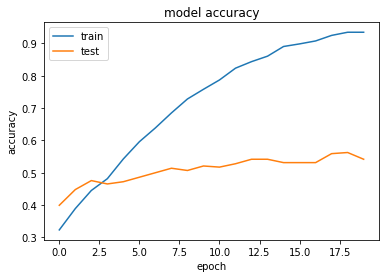

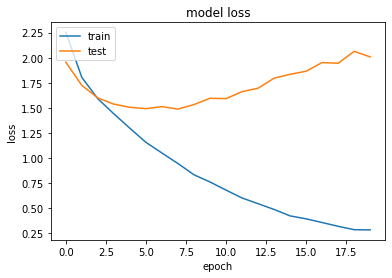

In [103]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Augmented_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Augmented_Model_Loss.png')
plt.show()

In [105]:
predictions = model.predict(X_test, batch_size=32)
predictions = predictions.argmax(axis = 1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform(predictions))
predictions = pd.DataFrame({'Predicted Values': predictions})

actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

finaldf = actual.join(predictions)
finaldf[140:150]


,Actual Values,Predicted Values
140,sad,sad
141,surprise,surprise
142,neutral,neutral
143,sad,neutral
144,fear,fear
145,sad,sad
146,disgust,disgust
147,angry,angry
148,surprise,surprise
149,angry,sad


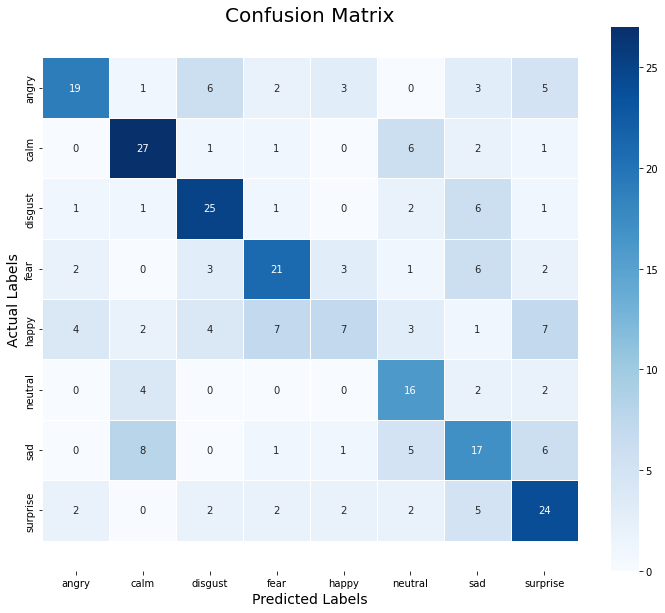

In [107]:
cm = confusion_matrix(actual, predictions)
plt.figure(figsize=(12,10))
cm = pd.DataFrame(cm, index= [i for i in lb.classes_], columns= [ i for i in lb.classes_])
ax = sns.heatmap(cm,linecolor='white', cmap='Blues', linewidths=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Augmented_Model_Confusion_Matrix.png')
plt.show()

In [108]:
from sklearn.metrics import classification_report
print(classification_report(actual, predictions, target_names= ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

              precision    recall  f1-score   support

       angry       0.68      0.49      0.57        39
        calm       0.63      0.71      0.67        38
     disgust       0.61      0.68      0.64        37
        fear       0.60      0.55      0.58        38
       happy       0.44      0.20      0.27        35
     neutral       0.46      0.67      0.54        24
         sad       0.40      0.45      0.43        38
    surprise       0.50      0.62      0.55        39

    accuracy                           0.54       288
   macro avg       0.54      0.54      0.53       288
weighted avg       0.54      0.54      0.53       288



In [111]:
#Hyperparameter Tuning 
from sklearn.model_selection import StratifiedShuffleSplit
X = conbined_df.drop(['emotion'], axis=1)
y = conbined_df.emotion
sss = StratifiedShuffleSplit(1,test_size=0.2, random_state=12)
for train_index, test_index in sss.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    


In [112]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [113]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [114]:
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

In [118]:
def make_classifier(optimizer='adam'):
    #BUILD CNN MODEL
    model = Sequential()
    model.add(Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Dropout(0.2))
    model.add(Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    model.summary()
    opt = tf.keras.optimizers.Adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

In [119]:
model = KerasClassifier(build_fn=make_classifier)
params = {'batch_size':[30,32,34],
            'nb_epoch':[ 50,75,100],
            'optimizer':['adam', 'SGD']}

grid_search = GridSearchCV(estimator=model, param_grid= params, scoring='accuracy',cv=5)
grid_search = grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_280 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_281 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_186 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_277 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_282 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_187 (MaxPooli  (None, 2, 128)           0         
 ng1D)                                               

99/99 [==============================] - 5s 40ms/step - loss: 2.0487 - accuracy: 0.3065
Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_292 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_293 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_194 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_289 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_294 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_195 (MaxPooli  (

99/99 [==============================] - 4s 37ms/step - loss: 2.0457 - accuracy: 0.2947
Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_304 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_305 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_202 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_301 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_306 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_203 (MaxPooli  

99/99 [==============================] - 4s 36ms/step - loss: 2.0434 - accuracy: 0.2984
Model: "sequential_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_316 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_317 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_210 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_313 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_318 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_211 (MaxPooli  

99/99 [==============================] - 4s 36ms/step - loss: 2.0633 - accuracy: 0.3148
Model: "sequential_110"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_328 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_329 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_218 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_325 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_330 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_219 (MaxPooli  

99/99 [==============================] - 4s 38ms/step - loss: 2.0629 - accuracy: 0.2855
Model: "sequential_114"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_340 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_341 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_226 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_337 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_342 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_227 (MaxPooli  

99/99 [==============================] - 4s 37ms/step - loss: 2.0713 - accuracy: 0.2879
Model: "sequential_118"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_352 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_353 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_234 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_349 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_354 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_235 (MaxPooli  

99/99 [==============================] - 4s 37ms/step - loss: 2.0582 - accuracy: 0.3045
Model: "sequential_122"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_364 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_365 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_242 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_361 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_366 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_243 (MaxPooli  

93/93 [==============================] - 4s 38ms/step - loss: 2.0798 - accuracy: 0.2957
Model: "sequential_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_376 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_377 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_250 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_373 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_378 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_251 (MaxPooli  

93/93 [==============================] - 4s 39ms/step - loss: 2.0656 - accuracy: 0.2856
Model: "sequential_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_388 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_389 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_258 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_385 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_390 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_259 (MaxPooli  

93/93 [==============================] - 4s 35ms/step - loss: 2.0853 - accuracy: 0.2838
Model: "sequential_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_400 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_401 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_266 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_397 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_402 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_267 (MaxPooli  

93/93 [==============================] - 4s 35ms/step - loss: 2.0745 - accuracy: 0.2913
Model: "sequential_138"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_412 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_413 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_274 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_409 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_414 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_275 (MaxPooli  

93/93 [==============================] - 4s 34ms/step - loss: 2.0642 - accuracy: 0.3038
Model: "sequential_142"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_424 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_425 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_282 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_421 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_426 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_283 (MaxPooli  

93/93 [==============================] - 4s 36ms/step - loss: 2.0521 - accuracy: 0.2987
Model: "sequential_146"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_436 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_437 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_290 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_433 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_438 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_291 (MaxPooli  

93/93 [==============================] - 4s 35ms/step - loss: 2.0785 - accuracy: 0.2866
Model: "sequential_150"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_448 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_449 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_298 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_445 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_450 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_299 (MaxPooli  

93/93 [==============================] - 4s 37ms/step - loss: 2.0856 - accuracy: 0.2991
Model: "sequential_154"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_460 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_461 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_306 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_457 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_462 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_307 (MaxPooli  

87/87 [==============================] - 4s 38ms/step - loss: 2.0700 - accuracy: 0.2937
Model: "sequential_158"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_472 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_473 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_314 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_469 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_474 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_315 (MaxPooli  

87/87 [==============================] - 4s 37ms/step - loss: 2.0672 - accuracy: 0.2872
Model: "sequential_162"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_484 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_485 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_322 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_481 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_486 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_323 (MaxPooli  

87/87 [==============================] - 4s 40ms/step - loss: 2.0711 - accuracy: 0.3008
Model: "sequential_166"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_496 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_497 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_330 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_493 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_498 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_331 (MaxPooli  

87/87 [==============================] - 4s 40ms/step - loss: 2.0965 - accuracy: 0.2843
Model: "sequential_170"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_508 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_509 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_338 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_505 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_510 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_339 (MaxPooli  

87/87 [==============================] - 4s 38ms/step - loss: 2.0874 - accuracy: 0.2926
Model: "sequential_174"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_520 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_521 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_346 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_517 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_522 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_347 (MaxPooli  

87/87 [==============================] - 4s 37ms/step - loss: 2.0733 - accuracy: 0.3018
Model: "sequential_178"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_532 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_533 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_354 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_529 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_534 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_355 (MaxPooli  

87/87 [==============================] - 4s 38ms/step - loss: 2.0811 - accuracy: 0.2967
Model: "sequential_182"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_544 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_545 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_362 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_541 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_546 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_363 (MaxPooli  

In [120]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'batch_size': 30, 'nb_epoch': 75, 'optimizer': 'adam'}
0.38035689990549837


In [121]:
print(grid_search.best_estimator_)

In [122]:
grid_search.best_index_

2